In [1]:
import math
import numpy as np
import pandas as pd
import sys
import re
import itertools
from functions import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as sklearnLDA
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy
import jellyfish as jf
import seaborn as sns
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10, 3)
%load_ext autoreload
%autoreload 2

/Users/jonathanma/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


### Data wrangling

#### Loaded dataframe with every actions for all students and dataframe with student pre/post scores

In [2]:
df.head(2)

,Activity,student,Time Stamp,Family,Family_tool,Family_default,Family_both,Action,Component,Outcome,...,current_is_circuit,current_#loops,current_#components,current_#battery,current_#circuitSwitch,current_#grabBagResistor,current_#lightBulb,current_#resistor,current_#seriesAmmeter,non_default_resistor_values
0,a2,10009106,1363981168331,Construct,Construct,Construct,Construct,add,wire,None,...,0,0,0,0,0,0,0,0,0,0
1,a2,10009106,1363981175425,Construct,Construct,Construct,Construct,add,battery,None,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_scores.head(2)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,...,Anon Student Id,incoming_knowledge,incoming_attitude,learning1score,learning1,learning2score,learning2,split pre,split post t2,three groups
0,March,not,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,high,low,NaN,low,NaN,low,high,high,HH
1,March,scaff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,high,low,NaN,low,NaN,low,high,high,HH


#### Crop activity data to get rid of activity #3

In [4]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

#### Define LL, LH, HL and HH groups based on median split on pre and bimodal dist of post tests

In [5]:
median_learning0 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning0,row,"z pre"),axis=1)
median_learning2 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning2,row,"z post t2"),axis=1)

In [6]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 22
high low 3
low high 38
low low 36


In [7]:
def label_3_groups (row):
    if row['split pre']  == 'high' and row['split post t2'] == 'high':
        return 'HH'
    if row['split pre']  == 'high' and row['split post t2'] == 'low':
        return 'HL'
    if row['split pre']  == 'low' and row['split post t2'] == 'high':
        return 'LH'
    if row['split pre']  == 'low' and row['split post t2'] == 'low':
        return 'LL'
df_scores['three groups'] = df_scores.apply (lambda row: label_3_groups (row),axis=1)

#### Convert action families into string sequences

In [8]:
def convert(action, test_granular = True):
        
    '''
    this function converts action families into single codes more amenable for sequence interpretation
    '''

    if test_granular:
        converter =  {"Construct" : "C",
        "Interface" : "I",
        "Pause" : "P",
        "Test_basic" : "T1",
        "Test_complex" : "Tm",
        "Test_other" : "To",
        "Test_simple" : "T2",
        }
    else:
        converter =  {"Construct" : "C",
        "Interface" : "I",
        "Pause" : "P",
        "Test_basic" : "T",
        "Test_complex" : "T",
        "Test_other" : "T",
        "Test_simple" : "T",
        }   
    return converter[action]

In [9]:
''' 
this is a test cell to assess regex
'''
ignore=['I', 'To']
sequence = list(df[df['student']==1075123]["Family"])

#prints raw sequence
print ''.join([convert(action) for action in sequence if convert(action) not in ignore])
print '------'

#prints blocked action sequence
block = re.sub(r'([A-Z][12m]{0,3})\1+', 
               r'\1',
               ''.join([convert(action) for action in sequence if convert(action) not in ignore]))
print block
print '------'

#prints blocked action for all action families except tests
block2 = re.sub(r'([CPI])\1+', 
                r'\1',
                ''.join([convert(action) for action in sequence if convert(action) not in ignore]))
print block2

CCCCCCCCCCCCCCCCCCCCCTmTmTmTmTmTmTmCTmTmTmCCCCCCCCTmCCCCCCT2T2T2T2T2T2T2T2CCCCCT1T1T1CT1T1T1CT1T1PT1CT1T1T1T1CT1T1PCCCCCCCT2T2T2T2CCCCCCCCCCT1T2T2T2T2T2PCCCCCCCCCCCCCCCCCTmTmPT2T1T2TmPCT2T2T2T2TmCTmTmTmPT2T2T2T2TmTmTmPT1T1CPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCT1TmTmTmTmTmPTmTmPCTmTmTmPCTmTmTmTmTmT1TmTmPCCCCCCCCCCCT1CCCT1CCCCCCCCCCCCCCCCPT2PCCCCCCCCCCCCCCCCCCCCCCTmCT1TmTmTmCTmTmCCTmTmTmCCTmT1TmPTmCTmCCCCCCCCCCCC
------
CTmCTmCTmCT2CT1CT1CT1PT1CT1CT1PCT2CT1T2PCTmPT2T1T2TmPCT2TmCTmPT2TmPT1CPCT1TmPTmPCTmPCTmT1TmPCT1CT1CPT2PCTmCT1TmCTmCTmCTmT1TmPTmCTmC
------
CTmTmTmTmTmTmTmCTmTmTmCTmCT2T2T2T2T2T2T2T2CT1T1T1CT1T1T1CT1T1PT1CT1T1T1T1CT1T1PCT2T2T2T2CT1T2T2T2T2T2PCTmTmPT2T1T2TmPCT2T2T2T2TmCTmTmTmPT2T2T2T2TmTmTmPT1T1CPCT1TmTmTmTmTmPTmTmPCTmTmTmPCTmTmTmTmTmT1TmTmPCT1CT1CPT2PCTmCT1TmTmTmCTmTmCTmTmTmCTmT1TmPTmCTmC


In [10]:
#choose which student groups to cluster
students = list(df_scores[(df_scores['split pre'] == 'low')]['student'])
# students = list(df['student'].unique())

In [32]:
'''
This creates dictionary (keys are student ID) and values are action sequences
'''
ignore=['I', 'To']
sequences = {student:'' for student in students}
for student in students:
    sequence = list(df[df['student']==student]["Family"])
    sequences[student] = re.sub(r'([A-Z][12m]{0,3})\1+',
               r'\1',
               ''.join([convert(action, False) for action in sequence if convert(action, False) not in ignore]))

In [33]:
'''
This creates a list of possible 4 action "phrases" (short sequences of actions) that will define
the dimensions along which we will cluster students.  The phrases cannot contain the same action in a row.
'''
# actions = ['C','P','T1','T2','Tm']
actions = ['C','P','T']
phrases1 = phrases2 = phrases3 = phrases4 =[]    
for action1 in actions:
    phrases1 = phrases1 + [action1]
    temp2 = actions[:]
    temp2.remove(action1)
    for action2 in temp2:
        phrases2 = phrases2 + [action1+action2]
        temp3 = actions[:]
        temp3.remove(action2)
        for action3 in temp3:
            phrases3 = phrases3 + [action1+action2+action3]
            temp4 = actions[:]
            temp4.remove(action3)
            for action4 in temp4: 
                phrases4 = phrases4 + [action1+action2+action3+action4]

phrases = phrases1 + phrases2 + phrases3 + phrases4                   

print len(phrases)             
# print phrases

45


In [34]:
'''
This creates a large matrix where each row is a student and each column represent a phrase.  
Each element is the normalized count of instances that the corresponding phrase appears
in that students whole sequence.
'''
# phrases = 'T1PT1C T1PCPCP TmCT2 PT2PCT2 CPCT2C CPCTmCP T1PCT1 T2CT2C CTmCTmCP TmCPCP'.split()
# phrases = ['CPCTC', 'CPCTCP', 'TCTC', 'TCPCP', 'CTCT', 'PTPCT', 'PTCT', 'TPTC', 'TPCPCP', 'TPCT']
# phrases = ['TP','PT', 'CT', 'TC']
# phrases = ['T2P', 'PT2', 'CT2', 'T2C']
# phrases = ['C', 'P', 'T1', 'T2', 'Tm']
# phrases = ['PT1', 'PT2', 'PTm', 'PC', 'T1P', 'T1T2', 'T1Tm', 'T1C', 'T2P', 'T2T1', 
#            'T2Tm', 'T2C', 'TmP', 'TmT1', 'TmT2', 'TmC', 'CP', 'CT1', 'CT2', 'CTm']
phrases = ['PT', 'PC', 'TP', 'TC', 'CP', 'CT']
X=np.zeros([len(students),len(phrases)])
nn = 0
for student in students:
    mm = 0
    for phrase in phrases:
        rx = r'(?=({0}))'.format(phrase)
        matches = re.finditer(rx,sequences[student])
        X[nn,mm] = len([match.group(1) for match in matches]) / float(len(sequences[student]))
        mm += 1
    nn += 1  

In [35]:
#do PCA to find which reduce dimensions on which we will cluster
# n_components=2
sklearn_pca = sklearnPCA()
pca = sklearn_pca.fit(X)
# transformed_X = np.dot(X, pca.components_.T)
X_tr = sklearn_pca.fit_transform(X)
# plt.figure(figsize=(5, 6))
# plt.scatter(transformed_X[:,0],transformed_X[:,1])
# plt.scatter(X_tr[:,0],X_tr[:,1])
# print(pca.components_[1:3,:]) 
print(pca.explained_variance_ratio_)

[6.15e-01 2.80e-01 1.02e-01 1.72e-03 3.28e-04 2.31e-04]


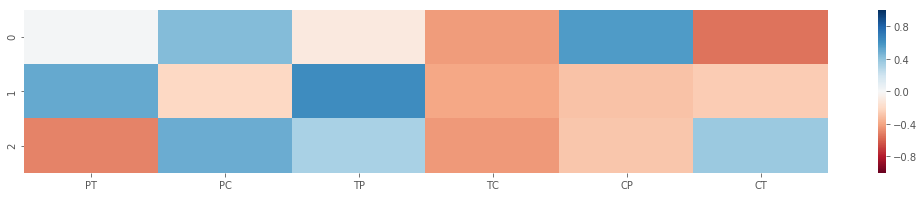

In [36]:
#visualize the principal components
plt.figure(figsize=(18, 3))
ax = sns.heatmap(pca.components_[0:3,0:10], cmap="RdBu", xticklabels=phrases[0:10], vmin=-1, vmax=1)

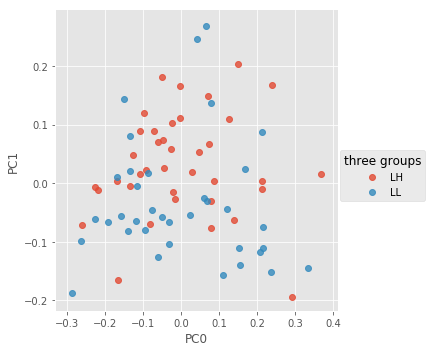

In [37]:
#visualize transformed data vs first two PCs and how they separate the groups
df_action_counts = pd.DataFrame(X_tr)
df_action_counts.columns = ['PC'+ str(nn) for nn in range(0,X_tr.shape[1])]
df_action_counts['student'] = students
# df_action_counts.head()
df_category = df_scores.loc[:,['student','three groups']]
df_action_counts = df_action_counts.join(df_category.set_index('student'), on='student')
# df_action_counts.head()
sns.lmplot('PC0', 'PC1', data=df_action_counts, hue='three groups', fit_reg=False)

### k-means clustering based on PCA

In [40]:
# do K-means clustering
K=3
Xarr = X_tr
# Number of clusters
kmeans = KMeans(n_clusters=K)
# Fitting the input data
kmeans = kmeans.fit(Xarr)
# Getting the cluster labels
labels = kmeans.predict(Xarr)
# Centroid values
centroids = kmeans.cluster_centers_

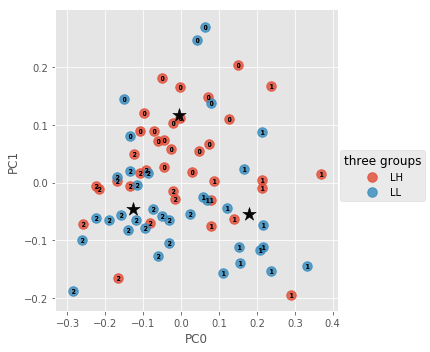

In [41]:
#plot the data with the cluster centroids along with cluster labels
g= sns.lmplot('PC0', 'PC1', data=df_action_counts, hue='three groups', fit_reg=False, scatter_kws={"s": 90})
markerShape = ['$0$', '$1$', '$2$', '$3$', '$4$', '$5$']
for i in range(K):
        points = np.array([Xarr[j] for j in range(len(Xarr)) if labels[j] == i])
        plt.scatter(points[:, 0], points[:, 1], s=20, marker=markerShape[i], color = 'k')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='#050505')

In [42]:
#plot cluster sizes
for nn in range(0, K):
    print len([label for label in labels if label == nn])

22
22
30


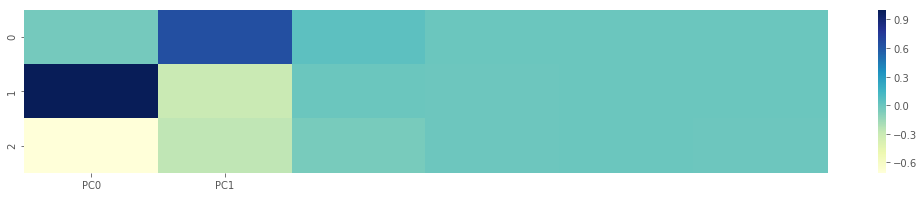

In [43]:
#visualize centroid coordinates wrt PCs
plt.figure(figsize=(18, 3))
# ax = sns.heatmap(centroids/np.max(centroids[:]), cmap="YlGnBu", xticklabels=phrases)
ax = sns.heatmap(centroids/np.max(centroids[:]), cmap="YlGnBu", xticklabels=['PC0','PC1'])

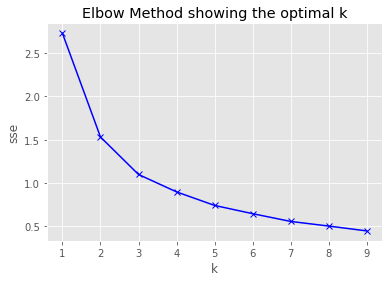

In [44]:
#see if there is elbow in SSE vs number of clusters k to determine optimal k
sse = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
#     sse.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'sqeuclidean'), axis=1)))
    sse.append(kmeanModel.inertia_)

plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('sse')
plt.title('Elbow Method showing the optimal k')
plt.show()

#### Creating new dataframe with clusters and pre-identified groups

In [45]:
df2 = pd.DataFrame(np.array([students,labels]).transpose())
df2.columns = ['student','k-means label']
df_category = df_scores.loc[:,['student','three groups']]
df2 = df2.join(df_category.set_index('student'), on='student')

# see how well k-means clusters match up with original groups
df2.groupby(['k-means label', 'three groups']).size().unstack().fillna(0)

three groups,LH,LL
k-means label,,
0,17,5
1,9,13
2,12,18


### Use hierarchical clustering based on similarity of sequences

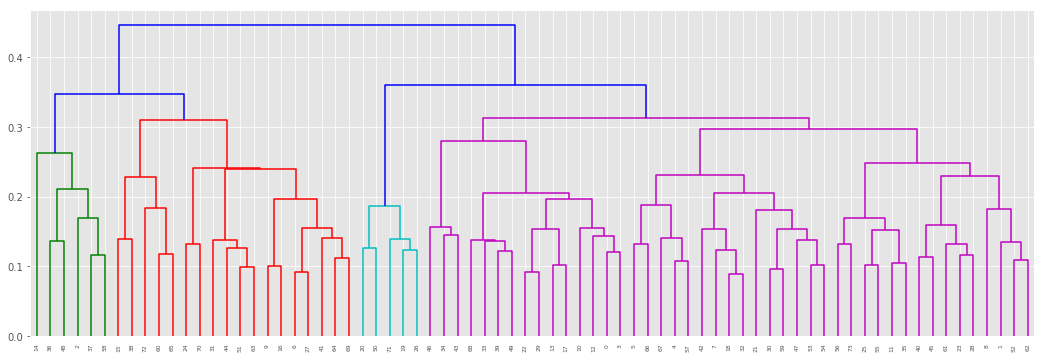

In [54]:
sentences = map(unicode, sequences.values())

def distmetric(coord):
    ''' Computes the 'distance' between two strings based on some metric.  Jaro distance gives a measure 
    of similarity between two strings normalized to 1 (1 is identical) thus why output is 1-jaro ''' 
    i, j = coord
    return 1 - jf.jaro_distance(sentences[i], sentences[j])
#     return jf.damerau_levenshtein_distance(sentences[i], sentences[j])

#creates tuple of two arrays, each gives row/column coordinates of upper triangle matrix that will match 
#each sequence to all other sequences
coord = np.triu_indices(len(sentences), 1)
#creates array of distances between every sequence as per the above specified coordinates
distmatrix = np.apply_along_axis(distmetric, 0, coord)
#create the cluster hierarchy
Z = scipy.cluster.hierarchy.linkage(distmatrix,'complete')
plt.figure(figsize=(18, 6))
max_d = 0.75*max(Z[:,2])
results = scipy.cluster.hierarchy.dendrogram(Z, color_threshold = max_d)

In [55]:
#see how well the clusters match up with original groups
clusters = scipy.cluster.hierarchy.fcluster(Z, max_d, criterion='distance')
df3 = pd.DataFrame(np.array([students,clusters]).transpose())
df3.columns = ['student','hierarchical label']
df_category3 = df_scores.loc[:,['student','three groups']]
df3 = df3.join(df_category3.set_index('student'), on='student')
# df3[df3['three groups']=='LH']
df3.groupby(['hierarchical label', 'three groups']).size().unstack()

three groups,LH,LL
hierarchical label,,
1,4,2
2,7,11
3,3,2
4,24,21
